# Deep Learning Project: Images Classificator (Dogs vs Cats)

In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import backend as K 
from keras.metrics import Precision, Recall
from tensorflow.keras.layers import Input # Input Layer
from tensorflow.keras.applications import DenseNet121 # Keras Application
from tensorflow.keras.layers import Dense # Dense Layer (Fully connected)
from tensorflow.keras.models import Model # Model Structure
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import ModelCheckpoint,  ReduceLROnPlateau
from tensorflow.keras.callbacks import EarlyStopping

In [4]:
dir_images = '../data/raw/images'

In [5]:
# Create DataFrame to store image paths and tags
data = []

# Loop through the images in the 'images' folder
for image_file in os.listdir(dir_images):
    # Get the full path of the image
    image_path = os.path.join(dir_images, image_file)
    # Assign tags based on file name
    if "dog" in image_file:
        label = "dog"
    elif "cat" in image_file:
        label = "cat"
    else: 
# If the file name does not contain "dog" or "cat", skip it
        continue
    # Agregar la ruta de la imagen y su etiqueta al DataFrame
    data.append({"image_path": image_path, "label": label})

df = pd.DataFrame(data)

df.to_csv("../data/raw/images.csv", index=False)

In [6]:
df.head()

,image_path,label
0,../data/raw/images\cat.0.jpg,cat
1,../data/raw/images\cat.1.jpg,cat
2,../data/raw/images\cat.10.jpg,cat
3,../data/raw/images\cat.100.jpg,cat
4,../data/raw/images\cat.1000.jpg,cat


In [7]:
df.shape

(25000, 2)

In [8]:
class_counts = df['label'].value_counts()
class_counts

label
cat    12500
dog    12500
Name: count, dtype: int64

Visualize the first 9 images in the dataset

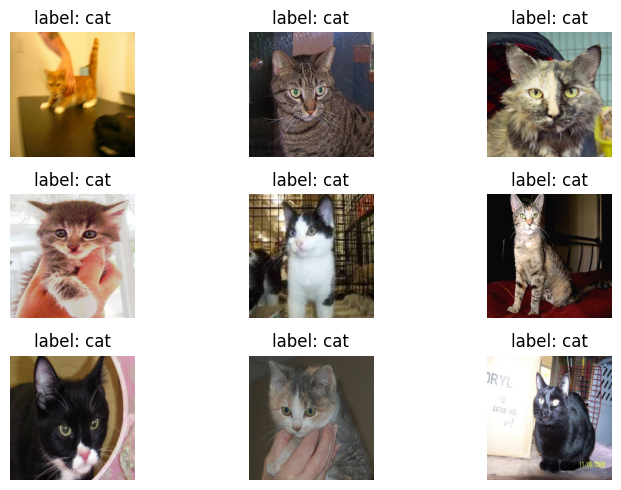

In [9]:
images = []
levels = []

for i in range(9):
    imag_path = df["image_path"].iloc[i]
    level = df["label"].iloc[i]
    levels.append(level)
    #Utilizamos la Librería PIL (pillow) para abrir y reajstar las imágenes
    img = Image.open(imag_path)
    img = img.resize((500, 500))
    #Normalización de las imágenes [0-1]
    img_array = np.array(img) / 255.0
    images.append(img_array)


plt.figure(figsize=(8, 5))

for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(images[i])
    plt.title(f'label: {levels[i]}')
    plt.axis('off')

plt.tight_layout()
plt.show()

Split the dataset in train, test and val

In [10]:
train_data, temp_data = train_test_split(df, test_size=0.3, random_state=42, stratify=df['label'])

val_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=42, stratify=temp_data['label'])

print("Train images:", len(train_data))
print("Validation images:", len(val_data))
print("Test images:", len(test_data))

Train images: 17500
Validation images: 3750
Test images: 3750


Using ImageDataGenerator to rescale de images and adjust the sizes

In [11]:
K.clear_session()

"""
Parameters
"""
epocas=10
longitud, altura = 224, 224
batch_size = 32
pasos = 500
validation_steps = 300
filtrosConv1 = 32
filtrosConv2 = 64
tamano_filtro1 = (3, 3)
tamano_filtro2 = (2, 2)
tamano_pool = (2, 2)
clases = 2
lr = 0.0004


datagen = ImageDataGenerator(
    rescale=1. / 255,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = datagen.flow_from_dataframe(
    train_data,
    x_col='image_path',
    y_col='label',
    color_mode='rgb',
    target_size=(longitud, altura),  # Reescalar imágenes a 224x224 píxeles
    batch_size=32,
    class_mode='binary'
)

val_generator = datagen.flow_from_dataframe(
    val_data,
    x_col = 'image_path',
    y_col = 'label',
    color_mode = 'rgb',
    target_size=(longitud, altura),  # Reescalar imágenes a 200x200 píxeles
    batch_size=32,
    class_mode = 'binary')


test_generator= datagen.flow_from_dataframe(
    test_data,
    x_col = "image_path",
    y_col = "label" ,
    color_mode = 'rgb',
    target_size=(longitud, altura),  # Reescalar imágenes a 200x200 píxeles
    batch_size=32,
    class_mode = 'binary')


Found 17500 validated image filenames belonging to 2 classes.
Found 3750 validated image filenames belonging to 2 classes.
Found 3750 validated image filenames belonging to 2 classes.


Using a Transfer Learning model: DenseNet121

In [13]:
input_shape=(224, 224, 3)

img_input = Input(shape=input_shape)
base_model = DenseNet121(include_top=False, 
                         input_tensor=img_input, 
                         input_shape=input_shape, 
                         pooling="max"
                         )
base_model.trainable = True

# Añadir la capa de salida para clasificación binaria
x = base_model.output
predictions = Dense(1, 
                    activation="sigmoid", 
                    name="predictions")(x)
model = Model(inputs=img_input, 
              outputs=predictions)

Compile the model:

In [14]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), #by default learning_rate=0.001
    loss='binary_crossentropy',
    metrics=['accuracy', Recall(), Precision()]
)

In [16]:
checkpoint = ModelCheckpoint("../models/dogs_vs_cats.keras",
                             monitor="val_accuracy",
                             verbose=2,
                             save_best_only=True,
                             save_weights_only=False,
                             mode="auto",
                             save_freq="epoch") 

reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.01,
                              patience=2,
                              verbose = 1,
                              mode = 'auto',
                              min_lr=0.00001)

early_stopping = EarlyStopping(monitor='val_recall', 
                               mode='max', 
                               verbose=1, 
                               patience=2, 
                               restore_best_weights=True)

Usign 6 epoch to train the model:

In [17]:
batch_size = 64

history = model.fit(
    train_generator,
    steps_per_epoch=len(train_data) // batch_size,
    epochs=6,
    validation_data=val_generator,
    validation_steps=len(val_data) // batch_size,
    callbacks=[checkpoint, reduce_lr, early_stopping],
    )

model.save('../models/cats_vs_dogs-densenet121_model.h5')

Epoch 1/6


c:\Users\crroj\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


273/273 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8667 - loss: 0.4796 - precision: 0.8698 - recall: 0.8646
Epoch 1: val_accuracy improved from -inf to 0.92511, saving model to ../models/dogs_vs_cats.keras
273/273 ━━━━━━━━━━━━━━━━━━━━ 686s 2s/step - accuracy: 0.8668 - loss: 0.4789 - precision: 0.8699 - recall: 0.8648 - val_accuracy: 0.9251 - val_loss: 0.1690 - val_precision: 0.9568 - val_recall: 0.8928 - learning_rate: 0.0010
Epoch 2/6
273/273 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9479 - loss: 0.1401 - precision: 0.9467 - recall: 0.9495
Epoch 2: val_accuracy improved from 0.92511 to 0.92834, saving model to ../models/dogs_vs_cats.keras
273/273 ━━━━━━━━━━━━━━━━━━━━ 630s 2s/step - accuracy: 0.9480 - loss: 0.1400 - precision: 0.9467 - recall: 0.9495 - val_accuracy: 0.9283 - val_loss: 0.1728 - val_precision: 0.8931 - val_recall: 0.9704 - learning_rate: 0.0010
Epoch 3/6
  1/273 ━━━━━━━━━━━━━━━━━━━━ 9:53 2s/step - accuracy: 0.9688 - loss: 0.1295 - precision: 1.0000 - recall: 0.947

c:\Users\crroj\AppData\Local\Programs\Python\Python312\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)



Epoch 3: val_accuracy did not improve from 0.92834

Epoch 3: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
273/273 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9688 - loss: 0.1295 - precision: 1.0000 - recall: 0.9474 - val_accuracy: 0.9211 - val_loss: 0.1755 - val_precision: 0.8500 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 4/6
273/273 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9608 - loss: 0.1092 - precision: 0.9464 - recall: 0.9761
Epoch 4: val_accuracy improved from 0.92834 to 0.96875, saving model to ../models/dogs_vs_cats.keras
273/273 ━━━━━━━━━━━━━━━━━━━━ 621s 2s/step - accuracy: 0.9608 - loss: 0.1091 - precision: 0.9464 - recall: 0.9761 - val_accuracy: 0.9688 - val_loss: 0.0799 - val_precision: 0.9653 - val_recall: 0.9716 - learning_rate: 1.0000e-05
Epoch 5/6
273/273 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9735 - loss: 0.0706 - precision: 0.9701 - recall: 0.9763
Epoch 5: val_accuracy improved from 0.96875 to 0.97360, saving model to ../m

Saving the model in the model folder

In [6]:
modelo = load_model('../models/cats_vs_dogs-densenet121_model.h5')

Evaluate the model with the test data:

In [21]:
evaluation_model = modelo.evaluate(test_generator, verbose=1)

118/118 ━━━━━━━━━━━━━━━━━━━━ 68s 554ms/step - accuracy: 0.9308 - loss: 0.1640 - precision: 0.8943 - recall: 0.9803


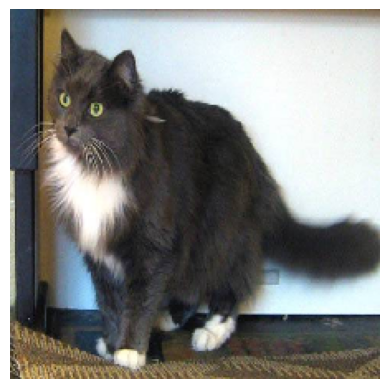

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
Output shape: (1, 1)
Output contents: [[0.00142562]]
cat


In [18]:
# Definir el generador de datos con las mismas configuraciones usadas durante el entrenamiento
datagen = ImageDataGenerator(
    rescale=1./255  # Ajuste de rescale usado durante el entrenamiento
    # Añadir otras transformaciones aquí si las usaste durante el entrenamiento, como rotation_range, width_shift_range, etc.
)

# Cargar y preprocesar la imagen
img_path = "../data/raw/samples/9.jpg"
img = image.load_img(img_path, target_size=(224, 224))
img = image.img_to_array(img)
img = np.expand_dims(img, axis=0)

# Preprocesar la imagen usando el generador de datos
img = datagen.flow(img, batch_size=1).__next__()

# Mostrar la imagen
plt.imshow(image.array_to_img(img[0]))
plt.axis('off')  # Ocultar ejes
plt.show()

# Hacer una predicción
output = modelo.predict(img)

# Imprimir la forma de la salida
print("Output shape:", output.shape)
print("Output contents:", output)

# Determinar la clase basada en una probabilidad única
if output[0] > 0.5:
    print("dog")
else:
    print("cat")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


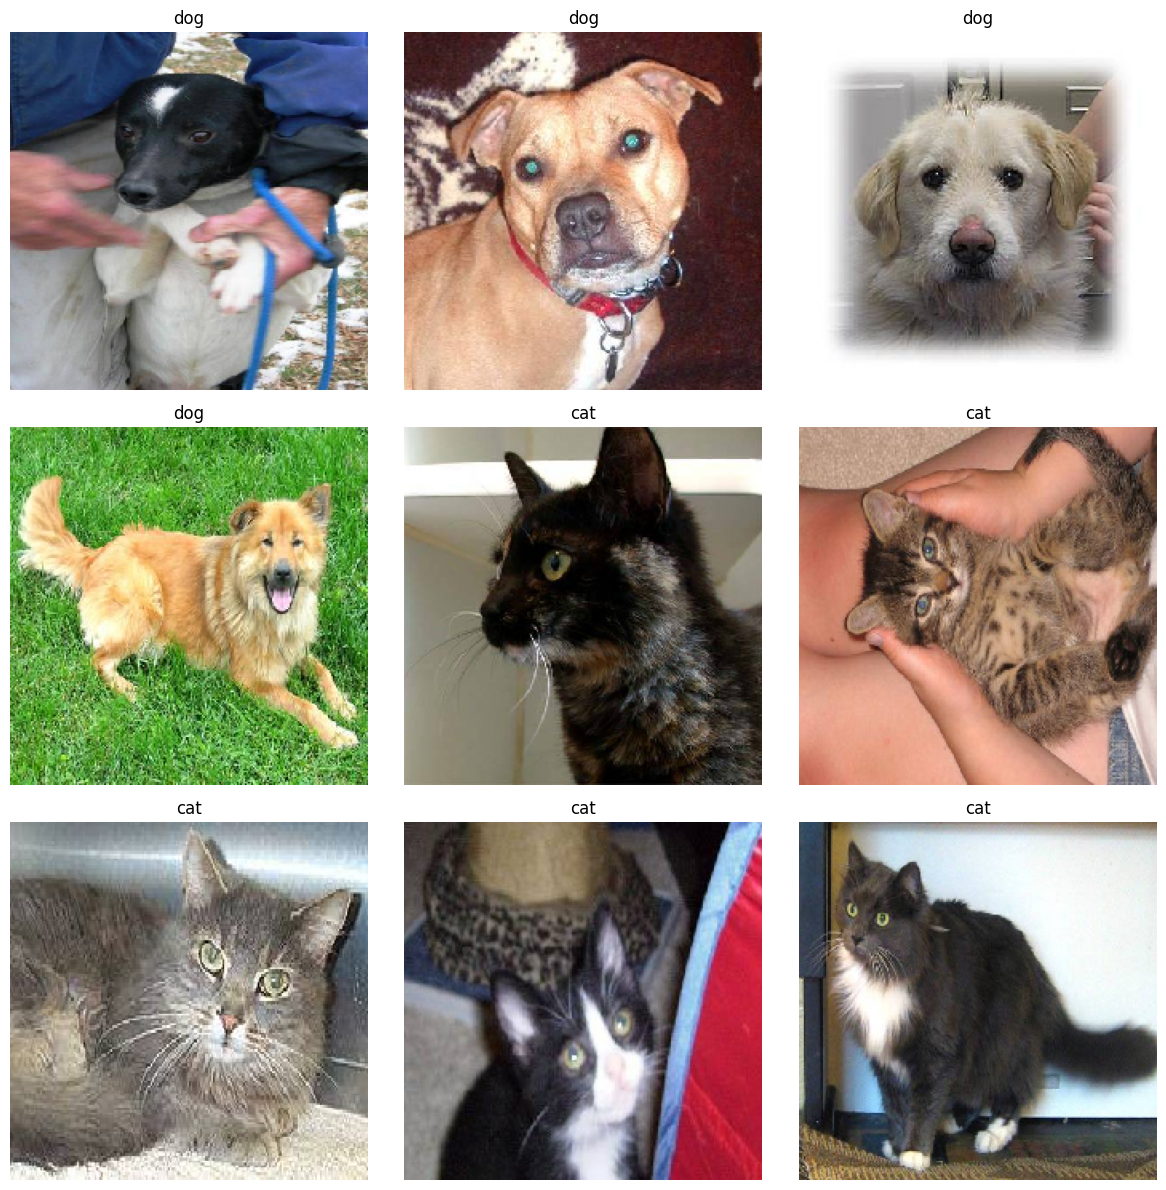

In [19]:
# Definir el generador de datos con las mismas configuraciones usadas durante el entrenamiento
datagen = ImageDataGenerator(
    rescale=1./255  # Ajuste de rescale usado durante el entrenamiento
    # Añadir otras transformaciones aquí si las usaste durante el entrenamiento, como rotation_range, width_shift_range, etc.
)

# Ruta a la carpeta con las imágenes
samples_path = "../data/raw/samples"
img_paths = [os.path.join(samples_path, fname) for fname in os.listdir(samples_path) if fname.endswith(".jpg")]

# Preparar la figura para mostrar las imágenes y sus predicciones
plt.figure(figsize=(12, 12))

for i, img_path in enumerate(img_paths):
    # Cargar y preprocesar la imagen
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    
    # Preprocesar la imagen usando el generador de datos
    img_array = datagen.flow(img_array, batch_size=1).__next__()

    # Hacer una predicción
    output = modelo.predict(img_array)

    # Determinar la clase
    if output.shape[1] == 1:
        # Modelo produce una sola probabilidad
        prediction = "dog" if output[0] > 0.5 else "cat"
    else:
        # Modelo produce un vector de dos probabilidades
        prediction = "cat" if output[0][0] > output[0][1] else "dog"

    # Mostrar la imagen y la predicción en una cuadrícula
    plt.subplot(3, 3, i + 1)
    plt.imshow(image.array_to_img(img_array[0]))
    plt.title(prediction)
    plt.axis('off')  # Ocultar ejes

# Ajustar el layout y mostrar la figura
plt.tight_layout()
plt.show()

CONLUSION:

In general, the metrics used to evaluate the model have been quite optimal and close to 1. In test we obtain an accuracy of 93% and a Recall of 98%.

In predicting new images, we observe that it has perfectly predicted the 9 previously viewed images.